In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify data shape
sample_images, sample_labels = next(iter(train_loader))
print("Image shape:", sample_images.shape)
print("Label shape:", sample_labels.shape)

Image shape: torch.Size([64, 1, 28, 28])
Label shape: torch.Size([64])


In [3]:
class ConditionalRBM(nn.Module):
    def __init__(self, visible_pixels=784, num_classes=10, hidden_dim=256, lr=0.001):
        super().__init__()
        self.visible_dim = visible_pixels + num_classes
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        self.lr = lr

        self.W = nn.Parameter(torch.randn(self.visible_dim, hidden_dim) * 0.01)
        self.visible_bias = nn.Parameter(torch.zeros(self.visible_dim))
        self.hidden_bias = nn.Parameter(torch.zeros(hidden_dim))

    def sigmoid(self, x):
        return 1 / (1 + torch.exp(-x))

    def sample_hidden(self, visible):
        activation = torch.matmul(visible, self.W) + self.hidden_bias
        hidden_probs = self.sigmoid(activation)
        return hidden_probs, torch.bernoulli(hidden_probs)

    def sample_visible(self, hidden, class_constraint=None):
        activation = torch.matmul(hidden, self.W.t()) + self.visible_bias
        visible_probs = self.sigmoid(activation)

        # Split into pixel and class components
        pixel_probs = visible_probs[:, :-self.num_classes]
        class_probs = visible_probs[:, -self.num_classes:]

        # Apply class constraint
        if class_constraint is not None:
            class_probs = torch.zeros_like(class_probs)
            class_probs[:, class_constraint] = 1.0

        # Sample visible units
        pixel_sample = torch.bernoulli(pixel_probs)
        class_sample = torch.bernoulli(class_probs)

        return torch.cat([pixel_sample, class_sample], dim=1), visible_probs

    def contrastive_divergence(self, visible_data, k=1):
        # Positive phase
        hidden_probs_pos, hidden_sample_pos = self.sample_hidden(visible_data)

        # Negative phase
        visible_recon = visible_data.clone()
        for _ in range(k):
            _, hidden_sample_neg = self.sample_hidden(visible_recon)
            visible_recon, _ = self.sample_visible(hidden_sample_neg)

        # Update parameters
        positive_association = torch.matmul(visible_data.t(), hidden_probs_pos)
        negative_association = torch.matmul(visible_recon.t(), self.sigmoid(torch.matmul(visible_recon, self.W) + self.hidden_bias))

        self.W.data += self.lr * (positive_association - negative_association) / visible_data.size(0)
        self.visible_bias.data += self.lr * (visible_data.mean(dim=0) - visible_recon.mean(dim=0))
        self.hidden_bias.data += self.lr * (hidden_probs_pos.mean(dim=0) - self.sigmoid(torch.matmul(visible_recon, self.W) + self.hidden_bias).mean(dim=0))

In [5]:
device = "mps"

crbm = ConditionalRBM(hidden_dim=512, lr=0.001).to(device)


In [6]:
# Training parameters
epochs = 20

for epoch in range(epochs):
    epoch_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        # Prepare data
        images = (images.view(-1, 784) > 0).float().to(device)  # Binarize
        labels_onehot = nn.functional.one_hot(labels, 10).float().to(device)
        visible_data = torch.cat([images, labels_onehot], dim=1)

        # Train on batch
        crbm.contrastive_divergence(visible_data)

        # Calculate reconstruction error
        with torch.no_grad():
            hidden_probs, _ = crbm.sample_hidden(visible_data)
            visible_recon, _ = crbm.sample_visible(hidden_probs)
            loss = torch.mean((visible_data[:, :784] - visible_recon[:, :784]) ** 2)
            epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 1/20, Loss: 0.2045
Epoch 2/20, Loss: 0.1719
Epoch 3/20, Loss: 0.1619
Epoch 4/20, Loss: 0.1490
Epoch 5/20, Loss: 0.1379
Epoch 6/20, Loss: 0.1300
Epoch 7/20, Loss: 0.1239
Epoch 8/20, Loss: 0.1193
Epoch 9/20, Loss: 0.1157
Epoch 10/20, Loss: 0.1126
Epoch 11/20, Loss: 0.1097
Epoch 12/20, Loss: 0.1071
Epoch 13/20, Loss: 0.1047
Epoch 14/20, Loss: 0.1025
Epoch 15/20, Loss: 0.1004
Epoch 16/20, Loss: 0.0984
Epoch 17/20, Loss: 0.0966
Epoch 18/20, Loss: 0.0949
Epoch 19/20, Loss: 0.0933
Epoch 20/20, Loss: 0.0918


In [7]:
def generate_digit(model, digit_class, num_samples=1, gibbs_steps=1000):
    model.eval()
    with torch.no_grad():
        # Initialize with random pixels and target class
        random_pixels = torch.bernoulli(torch.rand(num_samples, 784)).float().to(device)
        class_labels = torch.zeros(num_samples, model.num_classes).to(device)
        class_labels[:, digit_class] = 1.0

        visible = torch.cat([random_pixels, class_labels], dim=1)

        # Run Gibbs sampling
        for _ in range(gibbs_steps):
            _, hidden = model.sample_hidden(visible)
            visible, _ = model.sample_visible(hidden, class_constraint=digit_class)

        return visible[:, :784].cpu().numpy()

In [8]:
def plot_generated_samples(model, num_classes=10, samples_per_class=5):
    plt.figure(figsize=(15, 8))
    for class_idx in range(num_classes):
        for sample_idx in range(samples_per_class):
            ax = plt.subplot(num_classes, samples_per_class,
                             class_idx * samples_per_class + sample_idx + 1)
            generated = generate_digit(model, class_idx, gibbs_steps=1000)
            plt.imshow(generated[0].reshape(28, 28), cmap='gray')
            plt.axis('off')
            if sample_idx == 0:
                plt.title(f"Class {class_idx}")
    plt.tight_layout()
    plt.show()

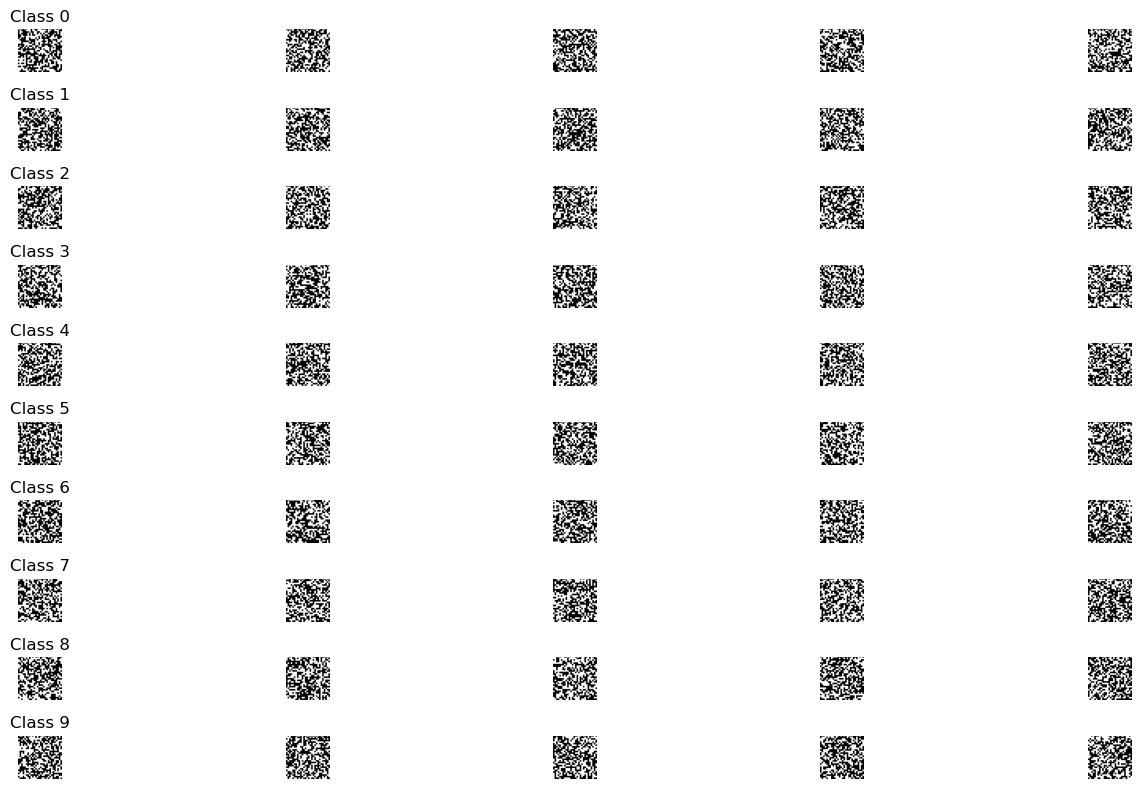

In [9]:
# Generate and plot samples for all classes
plot_generated_samples(crbm)